# Portfolio Project: Credit Card Fraud

## Imports

In [69]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocess
from imblearn.combine import SMOTETomek
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

#Pipeline
from imblearn.pipeline import Pipeline

#Feature Selection
from sklearn.feature_selection import mutual_info_classif, SelectKBest

#ML Validation etc.
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV, \
                                    train_test_split 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, \
                            classification_report, roc_auc_score


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 

## EDA

### Early EDA

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Most of the columns have undergone PCA transformation already in the interest of protecting the privacy, as such it is difficult to make analysis with the data by itself. 

In [4]:
# Create this for easier manipulation.
features = df.iloc[:,:-1] # It does not include the label
fraud_only = df[df['Class'] == 1].iloc[:,:-1]

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [67]:
df['Amount'].median()

22.0

#### Check Time Column

In [6]:
df['Time']

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

This column looks dubious. After some reading, it looks to be the time elapsed between the start of the data collection period and the transaction. This column I believe isn't useful as it is, and will need to be transformed because it is functioning almost as an index at the moment. 

#### Check for Missing Values

In [7]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no missing data

#### Check for Imbalance

In [8]:
class_val_count = df['Class'].value_counts() 
class_val_count  # Highly Imbalanced Data

0    284315
1       492
Name: Class, dtype: int64

In [9]:
f'Fraud accounts for {class_val_count[1] / class_val_count[0] * 100:0.2}% of the data'

'Fraud accounts for 0.17% of the data'

The data is highly imbalanced and SMOTE techniques will be used

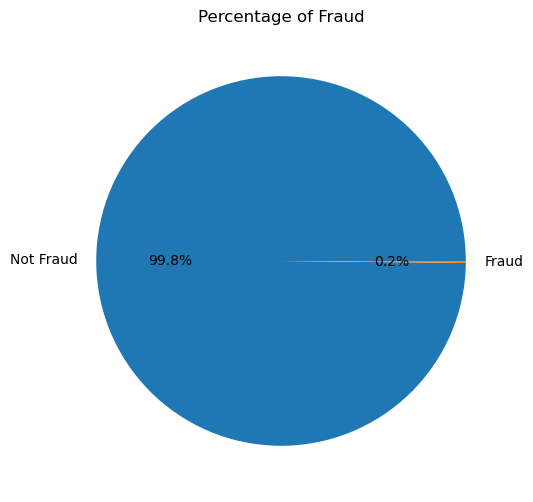

In [10]:
# Pieplot
pie_count = df['Class'].value_counts()
plt.figure(figsize = (6, 6))
plt.pie(pie_count, labels = ['Not Fraud', 'Fraud'], autopct='%1.1f%%')
plt.title('Percentage of Fraud');

#### Fraud Exploration

In [11]:
fraud_only['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
fraud_only['Amount'].sum()

60127.97

In [13]:
df['Amount'].sum()

25162590.009999998

In [68]:
fraud_only['Amount'].median()

9.25

### Graphs for Distribution

working on 0
working on 1
working on 2
working on 3
working on 4
working on 5
working on 6
working on 7
working on 8
working on 9
working on 10
working on 11
working on 12
working on 13
working on 14
working on 15
working on 16
working on 17
working on 18
working on 19
working on 20
working on 21
working on 22
working on 23
working on 24
working on 25
working on 26
working on 27
working on 28
working on 29


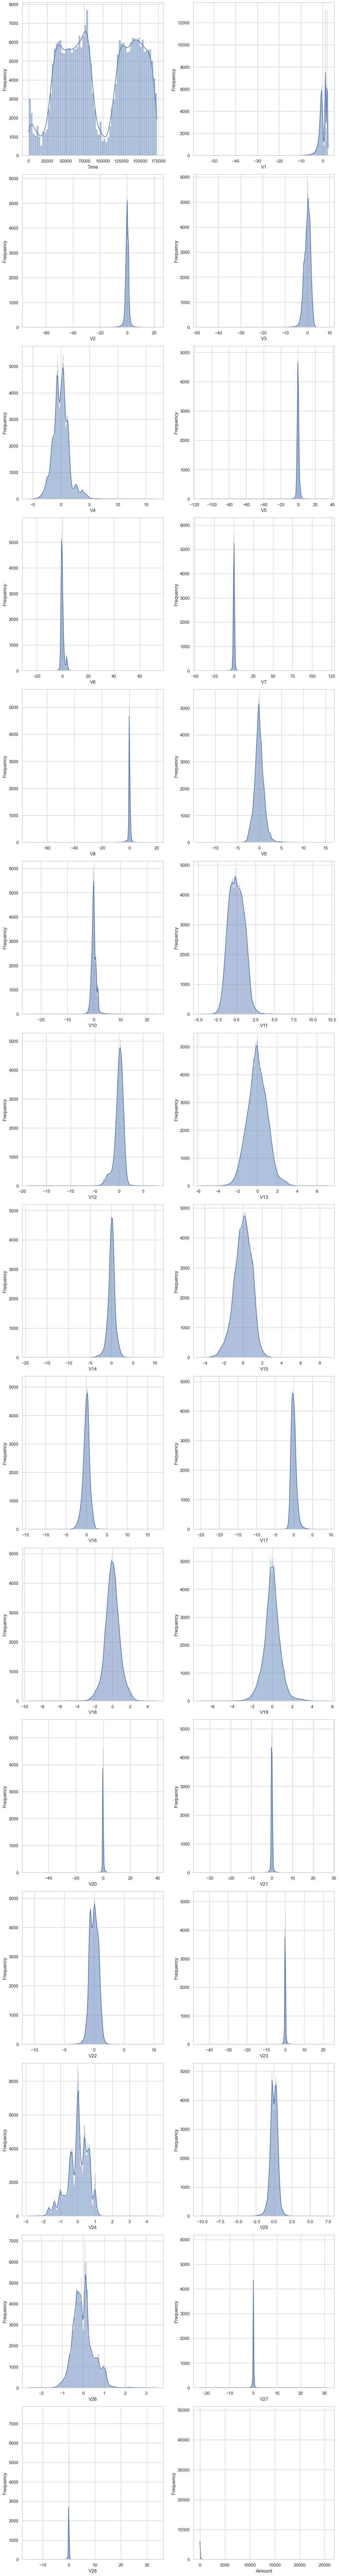

In [14]:
# Histogram
sns.set(style="whitegrid")
n_rows = (len(features.columns) + 1) // 2    # Floor division for if it's odd
fig, axes = plt.subplots(nrows = n_rows, ncols = 2, figsize = (12, 6 * n_rows))
axes = axes.flatten()                        # Flatten for iteration

# Plot
for i, column in enumerate(features.columns):
    print(f'working on {i}')                 # To see which one is being worked on
    sns.histplot(data = features, x = column, kde = True, ax = axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

The distribution of the histograms tell us the data has high kurtosis meaning there are most likely many outliers. Strangely, the Time column indicates there are two peaks within the data. More histograms will be created using only the positives to see if there is any predictions that can be made using this knowledge. 

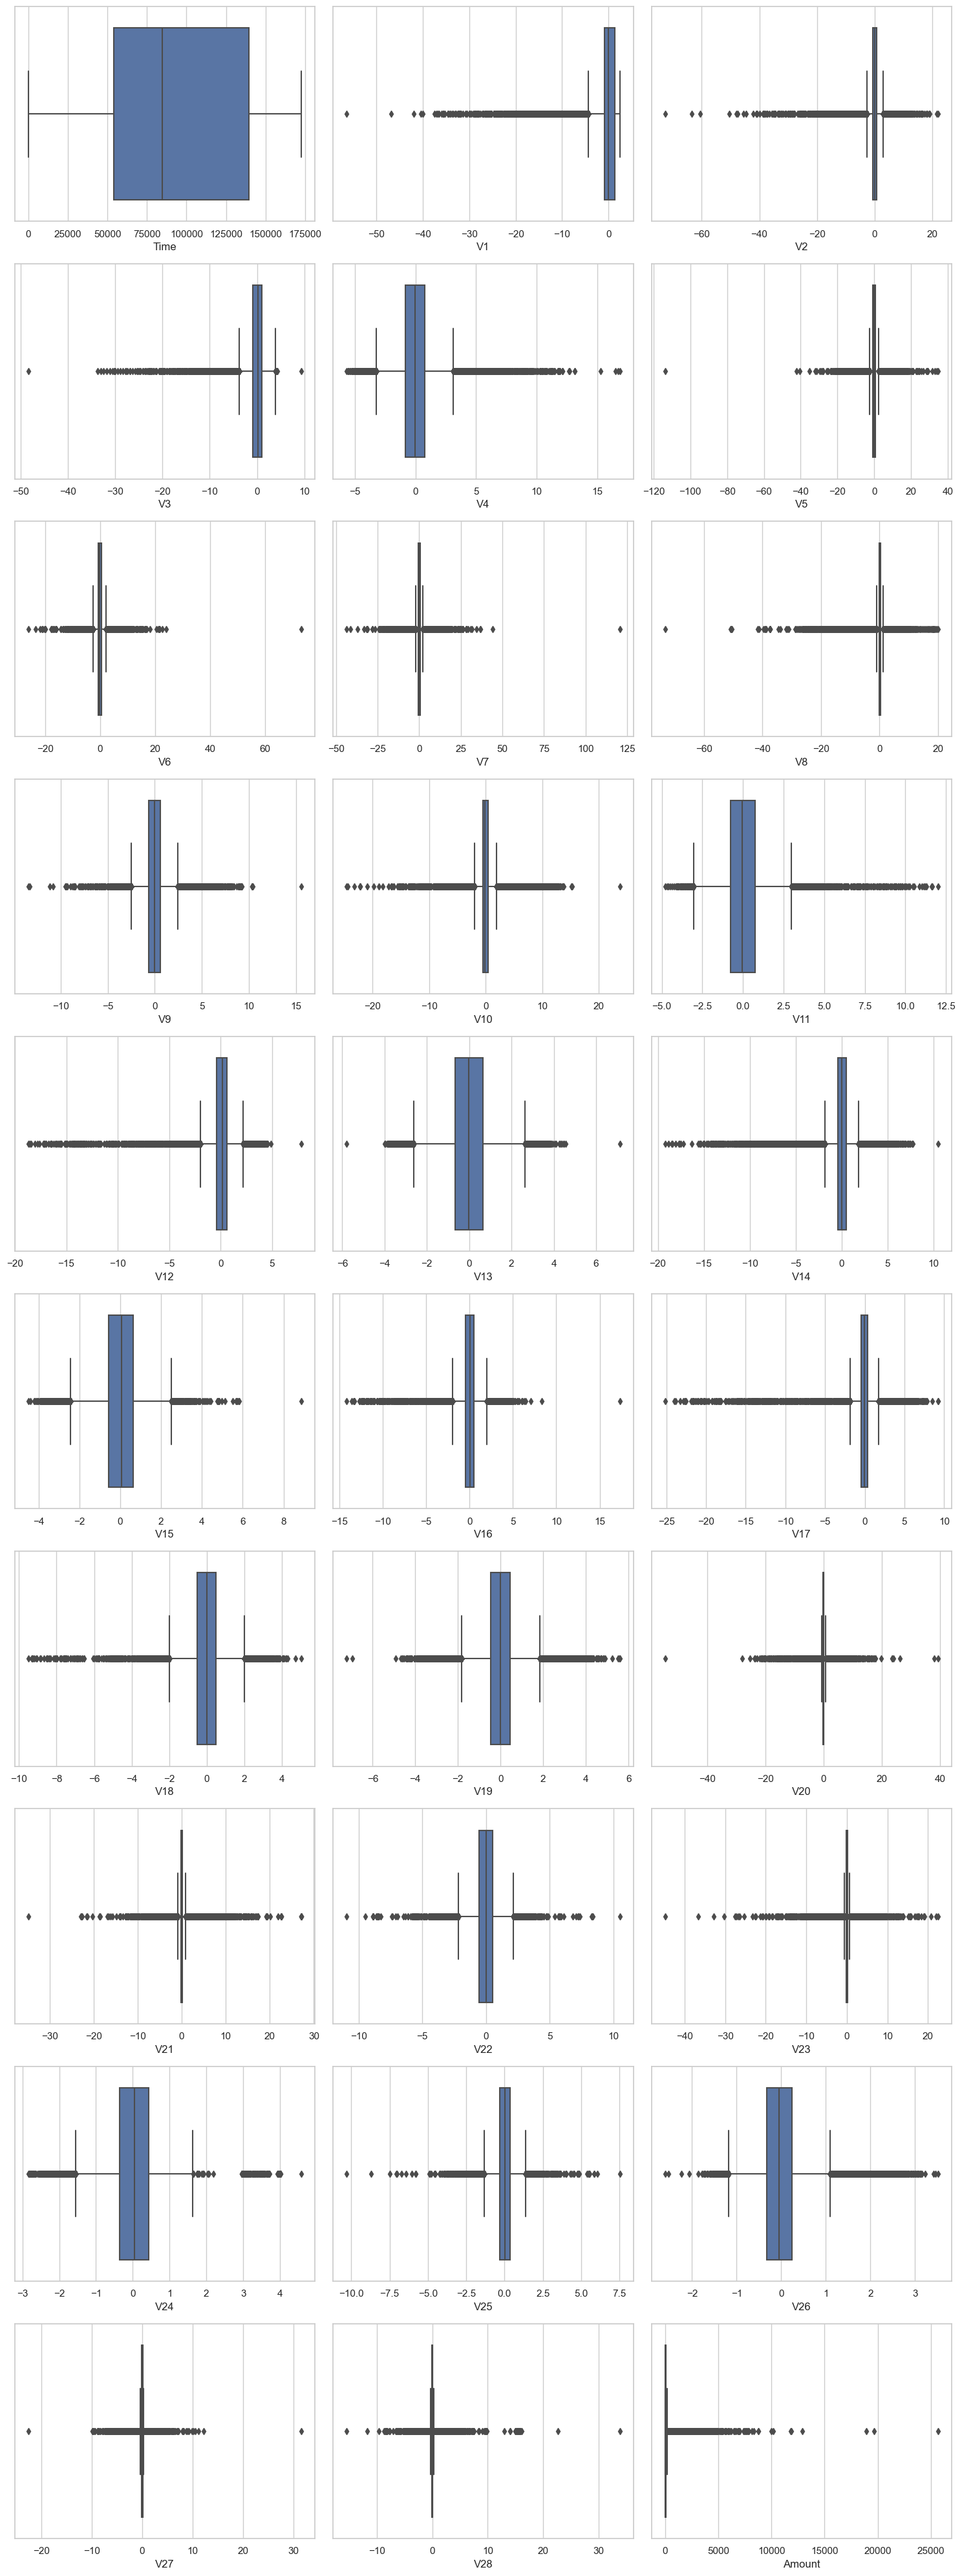

In [15]:
# Boxplot
n_rows = 10
fig, axes = plt.subplots(nrows = n_rows, ncols = 3, figsize = (15, 4 * n_rows))
axes = axes.flatten()                        # Flatten for iteration

# Plot
for i, column in enumerate(features.columns):
    sns.boxplot(data = features, x = column, ax = axes[i])
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

In [16]:
len(features.columns)

30

These boxplots tell confirm there are a lot of outliers. In order to use this data, I will be using robust scaler to remove the majority of the outliers.

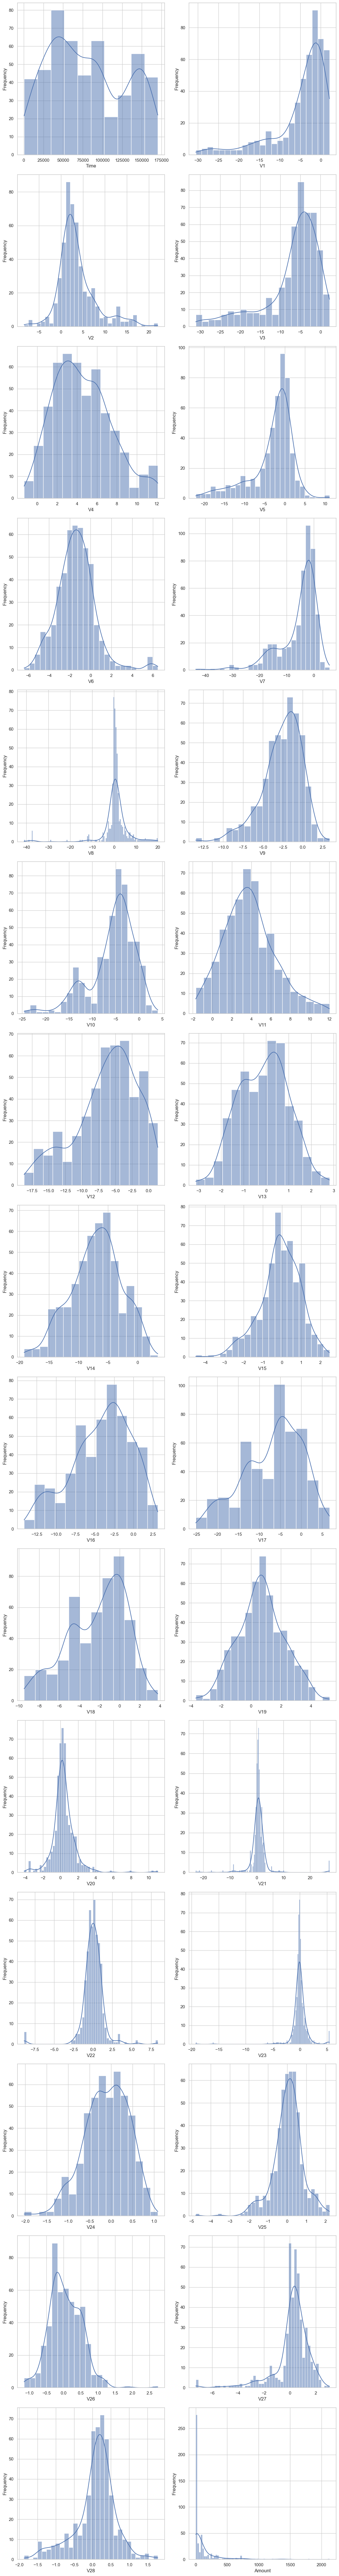

In [17]:
# Histogram for data of only fraud
n_rows = (len(fraud_only.columns) + 1) // 2    # Floor division for if it's odd
fig, axes = plt.subplots(nrows = n_rows, ncols = 2, figsize = (12, 6 * n_rows))
axes = axes.flatten()                        # Flatten for iteration

# Plot
for i, column in enumerate(fraud_only.columns):
    sns.histplot(data = fraud_only, x = column, kde = True, ax = axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

These distributions are far easier to see than the histogram of the entire dataset. It reveals a few features where the distribution is not normally distributed which can indicate features which have predictive power

#### Correlation Matrix

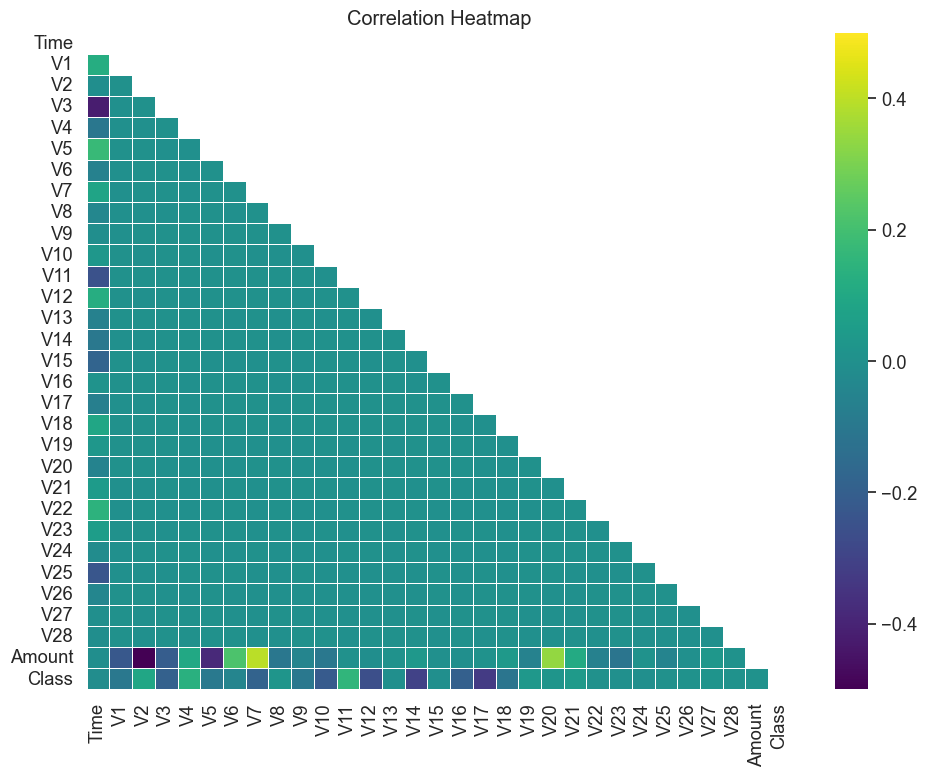

In [18]:
mask = np.triu(np.ones_like(df.corr(numeric_only = True), dtype = bool)) # Mask that covers upper half

plt.figure(figsize=(10, 8))
sns.set_theme(style = "white",
             font_scale = 1.2)

# Plot the heatmap with mask and without annotations
sns.heatmap(df.corr(numeric_only = True), mask = mask, robust = True, annot = False, 
            center = 0, vmin = -0.5, vmax = 0.5, cmap = "viridis", linewidths = .6) # not set to [1,-1] for 
                                                                                    # better visualization


# Set the title and adjust layout
plt.title("Correlation Heatmap")
plt.tight_layout()

# Show the plot
plt.show()

## Feature Engineering

### Time Column

The time column as it stands simply calculates the amount of time that has passed in seconds after the start of data collection, which isn't particularily useful. I am going to change that column into the hour. I do not know what hour data collection started, but between the two days of data collection there may be a pattern. It is observed afterall that the distribution for the time column is bimodal and more transactions occur at specific hours of the day. 

In [19]:
df['Hour'] = df['Time'] // 3600
df['Hour'] = np.where(df['Hour'] >= 24, df['Hour'] - 24, df['Hour'])
df['Hour']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
284802    23.0
284803    23.0
284804    23.0
284805    23.0
284806    23.0
Name: Hour, Length: 284807, dtype: float64

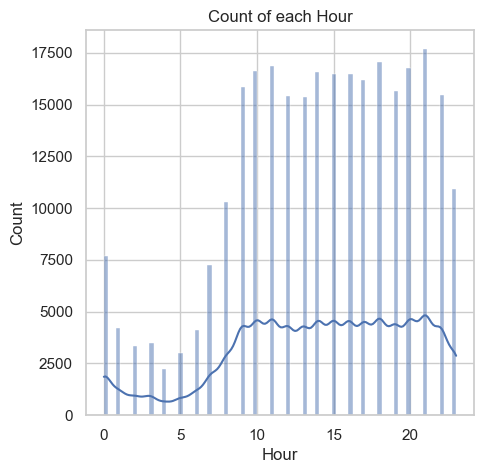

In [20]:
sns.set(style="whitegrid",
       font_scale = 1)
sns.set_theme
plt.figure(figsize = (5, 5))
sns.histplot(data = df, x = 'Hour', kde = True)
plt.title('Count of each Hour')
plt.show()

In [21]:
features_2 = df.drop(['Time','Class'], axis = 1)

## Modeling

### Train/Test Split

Here I am using holdout validation rather than kfold for the sake of simplicity 

In [22]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis = 1),
                                                    df['Class'],
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['Class'])

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.2, 
                                                  random_state = 42,
                                                  stratify = y_train)

### Preprocess

In the preprocessing stage I chose to simply use a Robust Scaler to normalize outliers and do not do much else to them. The reason for this is because I am attempting to detect fraud and if I were to impute or remove the values that are outliers, I would be affecting about half of the fraud cases. I am hoping by simply normalizing outliers I am allowing the model to detect outliers as a potential anomoly and potential fraud case. 

In [24]:
# The for transformation. At the moment, it is irrelevant, but it's coded in for future changes. 
columns = features_2.columns
dropcols = ['Time']

In [27]:
# Define Preprocessing Steps   
sm = SMOTETomek() # For both under and oversampling
    
ct = ColumnTransformer(
    transformers = [
        ('drop', 'drop', dropcols),
        ('scale', RobustScaler(), columns)
    ],
    remainder='passthrough'
)
      
steps =  [
    ('ct', ct),
    ('sm', sm)]
pre_pipe = Pipeline(steps)

In [28]:
# The X_train and y_train are transformed
X_transform, y_transform = pre_pipe.fit_resample(X_train, y_train)

In [29]:
# The X_test and X_val is transformed but does not undergo SMOTETomek
X_val_transformed = pre_pipe.named_steps['ct'].transform(X_val)
X_test_transformed = pre_pipe.named_steps['ct'].transform(X_test)

### Baseline Model

For the baseline model I chose to use Logistic Regression for its simplicity, speed, and interpretability. I will be using XgbBoost and Random Forest for their power, 

In [30]:
sns.set_style('white')

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45490
           1       0.06      0.86      0.11        79

    accuracy                           0.98     45569
   macro avg       0.53      0.92      0.55     45569
weighted avg       1.00      0.98      0.99     45569

ROC AUC: 0.918


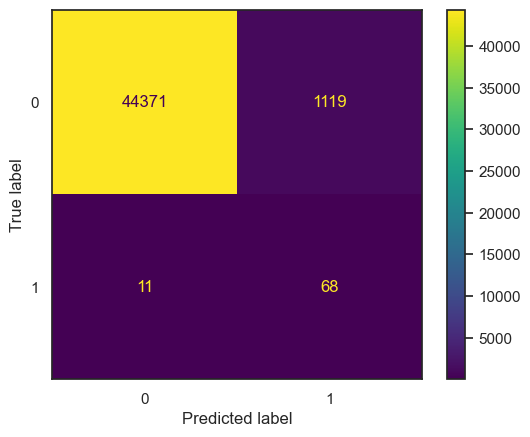

In [31]:
baseline = LogisticRegression(solver = 'liblinear')
baseline.fit(X_transform, y_transform)

y_pred = baseline.predict(X_val_transformed)
print(classification_report(y_val, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()

This model has very good recall and ROC AUC, however it has terrible precision. Ideally, we'd like to keep these numbers high but increase the precision.

### Feature Selection

In [32]:
X_df = pd.DataFrame(X_transform,columns=columns)

In [33]:
df_transform = X_df.copy()
df_transform['Class'] = y_transform

In [34]:
df_transform.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Class
0,-0.206425,0.723843,0.640948,0.075353,0.145424,-0.370382,0.555704,-0.017780,-0.367786,-0.485414,...,-0.447288,0.246735,0.408814,-0.406388,0.232177,1.617435,0.679893,-0.206846,-1.666667,0
1,0.539532,0.074388,0.075964,0.323666,-0.052891,-0.033066,-0.045680,-0.134049,0.088538,-0.022616,...,-0.659388,0.404498,-0.416266,0.260951,0.348894,-0.098446,0.017357,-0.167288,0.666667,0
2,0.754841,-0.543900,-0.596809,0.312106,-0.158501,0.440620,-0.561607,0.061004,0.980797,-0.557490,...,-0.085641,0.287052,-0.072409,-0.734721,0.731501,-0.109342,0.088158,2.082669,-0.555556,0
3,0.928507,0.020509,-1.218927,0.613430,0.863516,0.180991,0.347392,-0.274733,0.197323,0.559754,...,0.134160,-0.498419,-1.902975,0.844192,-0.643174,-0.168034,-0.767937,-0.292510,-0.444444,0
4,-0.263426,-0.727469,0.951707,-0.981267,-0.101673,-0.487017,-0.657832,-0.053558,1.614328,-1.107969,...,1.144322,0.035560,-0.012777,-1.113572,-0.054887,0.412859,-0.145680,-0.011143,0.444444,0


#### Mutual Information Statistic

Mutual Information Statistic is performed to get an idea of the features which should be kept into the final model. The features are all unnamed therefore it is typically difficult to determine the importance of each part. 

In [35]:
f_selector = SelectKBest(score_func=mutual_info_classif, k='all')
f_selector.fit(X_df, y_transform)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x000001E2D8F22D40>)

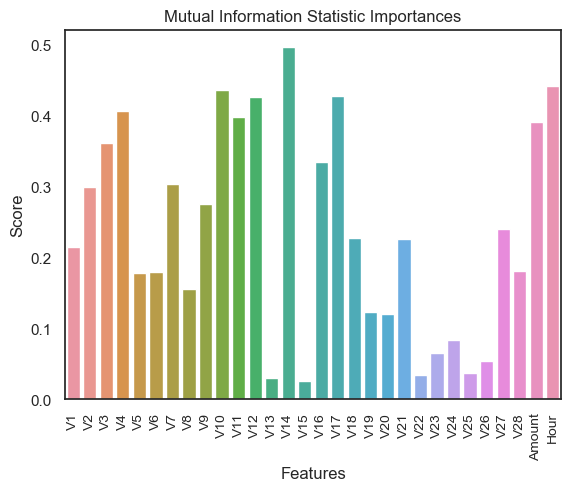

In [36]:
scores = f_selector.scores_
sns.barplot(x = columns, y = scores)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)
plt.title('Mutual Information Statistic Importances')
plt.xlabel('Features')
plt.ylabel('Score');

In [37]:
pd.DataFrame({'Feature':columns, 'Score':scores}).sort_values(by = 'Score', ascending = False)

,Feature,Score
13,V14,0.497043
29,Hour,0.442085
9,V10,0.437513
16,V17,0.428547
11,V12,0.427047
3,V4,0.407753
10,V11,0.399374
28,Amount,0.391502
2,V3,0.361326
15,V16,0.335679


Here we have the features ordered by their importance. 

#### Correlation Matrix

Performing another Correlation Matrix, this time after SMOTE has been applied allows us to see the relationships that have been better highlighted. 

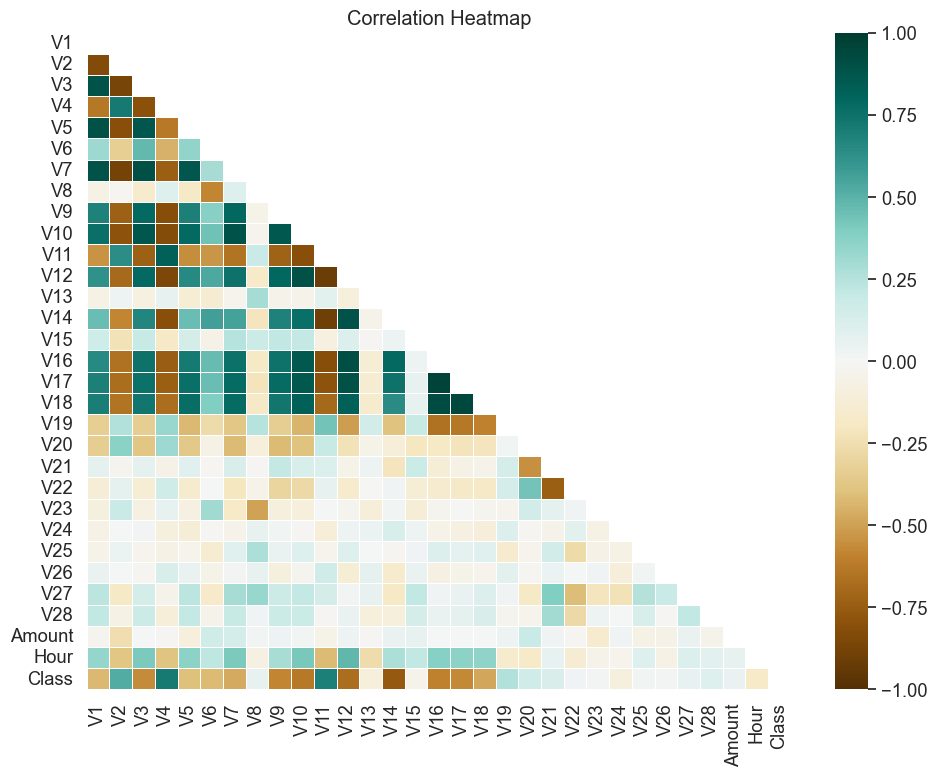

In [38]:
mask = np.triu(np.ones_like(df_transform.corr(numeric_only = True), dtype = bool)) # Mask that covers upper half

plt.figure(figsize=(10, 8))
sns.set_theme(style = "white",
             font_scale = 1.2)

# Plot the heatmap with mask and without annotations
df_corr = df_transform.corr(numeric_only = True)
sns.heatmap(df_corr, mask = mask, robust = True, annot = False, 
            center = 0, vmin = -1, vmax = 1, cmap = "BrBG", linewidths = .6)


# Set the title and adjust layout
plt.title("Correlation Heatmap")
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
df_corr['Class']#.sort_values()

V1       -0.427150
V2        0.519747
V3       -0.566502
V4        0.712789
V5       -0.400389
V6       -0.415323
V7       -0.473312
V8        0.066782
V9       -0.583437
V10      -0.631079
V11       0.688698
V12      -0.679153
V13      -0.101524
V14      -0.760482
V15      -0.041313
V16      -0.594691
V17      -0.576230
V18      -0.477239
V19       0.258544
V20       0.160579
V21       0.118823
V22       0.026144
V23       0.010148
V24      -0.091469
V25       0.019669
V26       0.014468
V27       0.065927
V28       0.094442
Amount    0.053610
Hour     -0.178252
Class     1.000000
Name: Class, dtype: float64

Here I'm looking at the values that are more extreme.

#### Features Weights by Logistic Regression

Something else we can consider will be the Feature Weights as given by the Logistic Regression itself

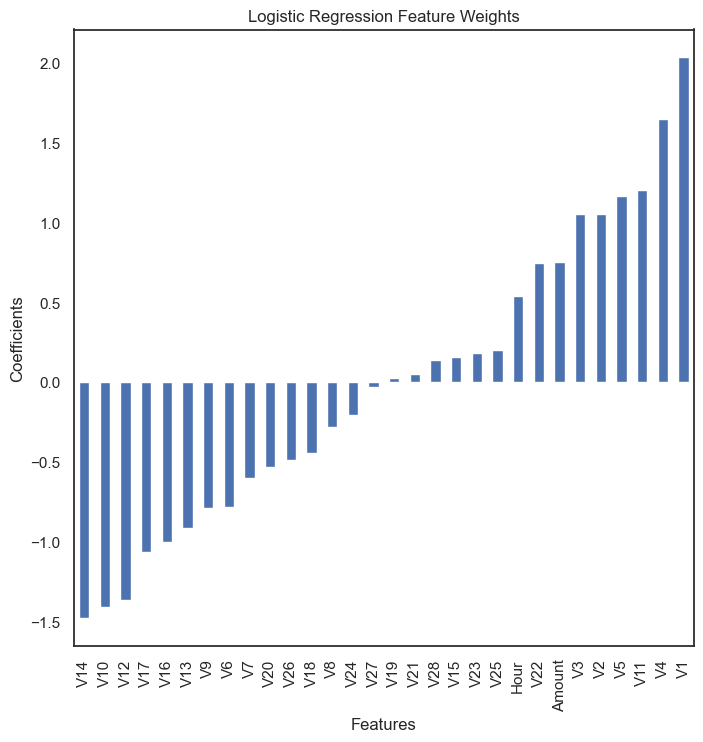

In [40]:
sns.set(style="white",
       font_scale = 1)
plt.figure(figsize=(8, 8))
pd.Series(baseline.coef_[0], index= columns).sort_values().plot(kind = 'bar')
plt.title('Logistic Regression Feature Weights')
plt.ylabel('Coefficients')
plt.xlabel('Features')
plt.show();

In [41]:
pd.DataFrame({'Feature':columns, 'Score':baseline.coef_[0]})

,Feature,Score
0,V1,2.029296
1,V2,1.052504
2,V3,1.050672
3,V4,1.642627
4,V5,1.165980
5,V6,-0.784112
6,V7,-0.601096
7,V8,-0.279799
8,V9,-0.786977
9,V10,-1.406998


#### All three combined

It's difficult to see all the feature importances, so I made this section to line them up side by side. The final table has a column called "Total" which is the sum of the magnitudes of the other columns. 

In [42]:
feat_select_df = pd.DataFrame(df_corr['Class'])
feat_select_df = feat_select_df.rename(columns = {'Class':'Corr_Matrix'})
feat_select_df = feat_select_df.drop('Class', axis = 0) # Drop class row
feat_select_df['MIS'] = scores                          # Add mutual Information Statistic
feat_select_df['LR'] = baseline.coef_[0]                # Add Logistic Regression Importances
feat_select_df

,Corr_Matrix,MIS,LR
V1,-0.427150,0.215717,2.029296
V2,0.519747,0.300397,1.052504
V3,-0.566502,0.361326,1.050672
V4,0.712789,0.407753,1.642627
V5,-0.400389,0.177758,1.165980
V6,-0.415323,0.179560,-0.784112
V7,-0.473312,0.304205,-0.601096
V8,0.066782,0.156397,-0.279799
V9,-0.583437,0.275921,-0.786977
V10,-0.631079,0.437513,-1.406998


In [43]:
# Specify axis so it's by row and abs for absolute value
feat_select_df['Total'] = feat_select_df.apply(abs).sum(axis = 1) 

In [44]:
feat_select_df.sort_values(by = 'Total', ascending = False)

,Corr_Matrix,MIS,LR,Total
V4,0.712789,0.407753,1.642627,2.763169
V14,-0.760482,0.497043,-1.471940,2.729466
V1,-0.427150,0.215717,2.029296,2.672163
V10,-0.631079,0.437513,-1.406998,2.475590
V12,-0.679153,0.427047,-1.359822,2.466021
V11,0.688698,0.399374,1.201308,2.289380
V17,-0.576230,0.428547,-1.062817,2.067594
V3,-0.566502,0.361326,1.050672,1.978500
V16,-0.594691,0.335679,-0.998677,1.929047
V2,0.519747,0.300397,1.052504,1.872649


In [45]:
important_feats = feat_select_df[feat_select_df['Total'] > 1].\
            sort_values(by = 'Total', ascending = False).index.tolist()
important_feats

['V4',
 'V14',
 'V1',
 'V10',
 'V12',
 'V11',
 'V17',
 'V3',
 'V16',
 'V2',
 'V5',
 'V9',
 'V6',
 'V7',
 'Amount',
 'Hour',
 'V18',
 'V13']

In [46]:
len(important_feats)

18

we arrive at 18 features which will be used. 7 have been dropped in hopes of reducing the curse of dimensionality 

### Algorithm Selection

In [47]:
X_train_final = X_df[important_feats]
X_val_final = pd.DataFrame(X_val_transformed, columns=columns)[important_feats]
X_test_final = pd.DataFrame(X_test_transformed, columns=columns)[important_feats]

In [50]:
def Model(model, X_testing = X_val_final, y_testing = y_val):
    model.fit(X_train_final, y_transform)

    y_pred = model.predict(X_testing)

    print(classification_report(y_testing, y_pred))
    print('ROC AUC: %.3f' % roc_auc_score(y_testing, y_pred))

    cm = confusion_matrix(y_testing, y_pred)
    
    return model, cm

#### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     45490
           1       0.05      0.89      0.10        79

    accuracy                           0.97     45569
   macro avg       0.53      0.93      0.54     45569
weighted avg       1.00      0.97      0.98     45569

ROC AUC: 0.929


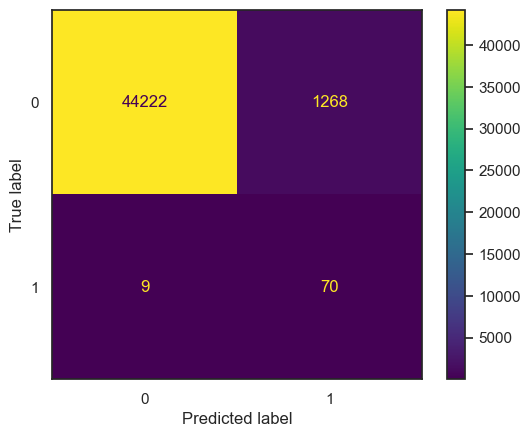

In [52]:
LR, cm = Model(LogisticRegression(solver = 'liblinear'))
ConfusionMatrixDisplay(cm).plot()

Compared to baseline, it has a higher ROC, but an even lower Precision. The reason why this is not good, is because either agents will be wasting their time trying to figure out of the card is fraudulent or a lot of customers are getting a lot of pings for fraudulent transactions. 

#### Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.34      0.77      0.48        79

    accuracy                           1.00     45569
   macro avg       0.67      0.88      0.74     45569
weighted avg       1.00      1.00      1.00     45569

ROC AUC: 0.885


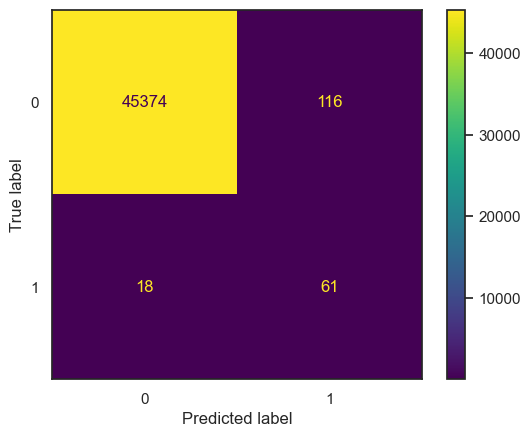

In [53]:
DT, cm = Model(DecisionTreeClassifier())
ConfusionMatrixDisplay(cm).plot()

the precision is much better here, although it has a lower ROC

#### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.84      0.77      0.80        79

    accuracy                           1.00     45569
   macro avg       0.92      0.89      0.90     45569
weighted avg       1.00      1.00      1.00     45569

ROC AUC: 0.886


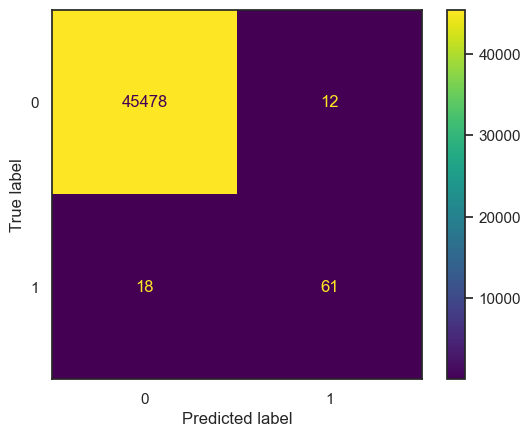

In [54]:
RF, cm = Model(RandomForestClassifier())
ConfusionMatrixDisplay(cm).plot()

The precision on random forest classifier is very good in comparison to the baseline

#### XG boost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.81      0.80      0.80        79

    accuracy                           1.00     45569
   macro avg       0.90      0.90      0.90     45569
weighted avg       1.00      1.00      1.00     45569

ROC AUC: 0.899


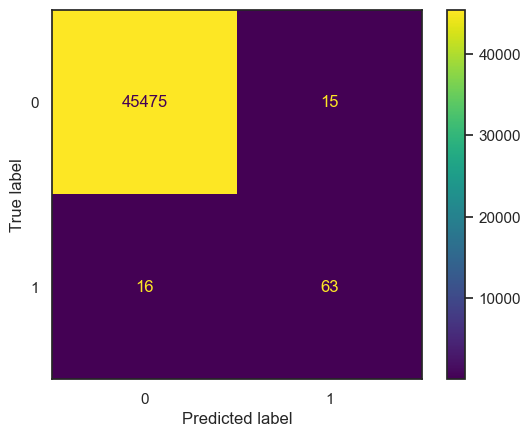

In [63]:
XGB, cm = Model(XGBClassifier())
ConfusionMatrixDisplay(cm).plot()

Higher ROC AUC, slightly lower precision. Since we are trying to maximize ROC AUC, it looks like XGBoost is the winner in terms of algorithm selection. 

The reason why I think XGboost is better compared to Logistic Regression is because of the Precision. Although Logistic Regression does have higher ROC AUC, the precision is just too low for me to consider it a viable option. 

#### Model Stacking

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.90      0.77      0.83        79

    accuracy                           1.00     45569
   macro avg       0.95      0.89      0.91     45569
weighted avg       1.00      1.00      1.00     45569

ROC AUC: 0.886


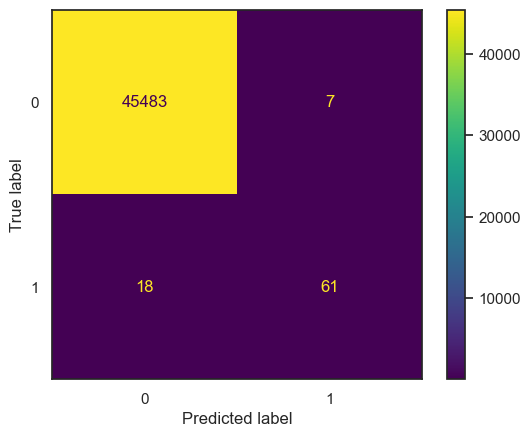

In [86]:
base_models = [
    ('XGB', XGBClassifier()),
    ('RF', RandomForestClassifier()),
    ('DT', DecisionTreeClassifier())
]

stacking_classifier = StackingClassifier(estimators = base_models,
                                         final_estimator = LogisticRegression())

Stack, cm = Model(stacking_classifier)
ConfusionMatrixDisplay(cm).plot()

The Model has a ROC AUC slightly lower than the XGBoost but it has higher precision of the minority class. Due to the much greater time it takes to train the model after stacking, it was deemed more worthwhile to simply use XGB.

### Hyperparameter Tuning

In [93]:
XGB_tune = XGBClassifier(tree_method = 'gpu_hist')

grid = {
    'eta': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4]
}

grid_search = GridSearchCV(estimator = XGB_tune, param_grid = grid,
                           scoring = 'roc_auc', cv = 5)
grid_search.fit(X_train_final, y_transform)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7],
                         'min_child_weight': [1, 2, 3, 4]},
             scoring='roc_auc')

In [94]:
grid_search.best_params_

{'eta': 0.3, 'max_depth': 6, 'min_child_weight': 1}

In [95]:
grid_search.best_score_

0.9999871909714357

From hyperparameter tuning, it seems the defaul parameters were fine.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.77      0.78      0.77        79

    accuracy                           1.00     45569
   macro avg       0.88      0.89      0.89     45569
weighted avg       1.00      1.00      1.00     45569

ROC AUC: 0.892


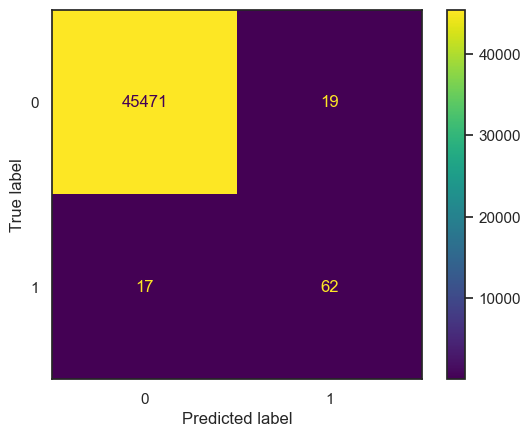

In [97]:
XGB_tune, cm = Model(XGBClassifier(tree_method = 'gpu_hist'))
ConfusionMatrixDisplay(cm).plot()

After hypertuning, it seems worse than the original, but that's most likely due to the random state not being set. Regardless, the hyperparameters labeled as best were the default parameters. 

### Deep Learning

In [181]:
model = tf.keras.models.Sequential([
    Dense(512, activation='relu', input_shape=(X_transform.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['AUC','TruePositives'])

# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_auc', patience = 5, restore_best_weights  =True)

In [182]:
model.fit(X_transform, y_transform, epochs=25, batch_size=128, 
          validation_data=(X_val_transformed, y_val), callbacks=[early_stopping])

Epoch 1/25
2844/2844 [==============================] - 15s 5ms/step - loss: 0.0259 - auc: 0.9992 - true_positives: 180868.0000 - val_loss: 0.0173 - val_auc: 0.9169 - val_true_positives: 64.0000
Epoch 2/25
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0077 - auc: 0.9997 - true_positives: 181823.0000 - val_loss: 0.0152 - val_auc: 0.9173 - val_true_positives: 63.0000
Epoch 3/25
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0055 - auc: 0.9998 - true_positives: 181857.0000 - val_loss: 0.0196 - val_auc: 0.9172 - val_true_positives: 65.0000
Epoch 4/25
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0048 - auc: 0.9998 - true_positives: 181877.0000 - val_loss: 0.0205 - val_auc: 0.8919 - val_true_positives: 62.0000
Epoch 5/25
2844/2844 [==============================] - 14s 5ms/step - loss: 0.0041 - auc: 0.9998 - true_positives: 181906.0000 - val_loss: 0.0234 - val_auc: 0.9172 - val_true_positives: 65.0000
Epoch 6/25
2844/2844 [===

In [183]:
loss, auc, tp = model.evaluate(X_test_transformed, y_test)

1781/1781 [==============================] - 3s 2ms/step - loss: 0.0119 - auc: 0.9332 - true_positives: 84.0000


1781/1781 [==============================] - 2s 1ms/step


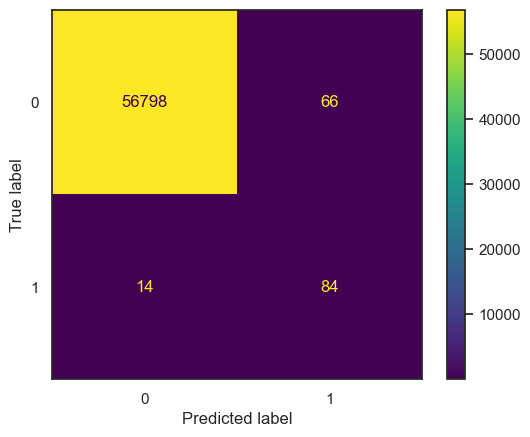

In [184]:
y_pred_probs = model.predict(X_test_transformed) # making this step because the model predicts in probability
y_pred = (y_pred_probs > 0.5).astype(int)       # this then makes them either or
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

The deep learning model has a higher ROC AUC than the XGBoost but once again it lacks precision

### Final Model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.85      0.77        98

    accuracy                           1.00     56962
   macro avg       0.85      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.923


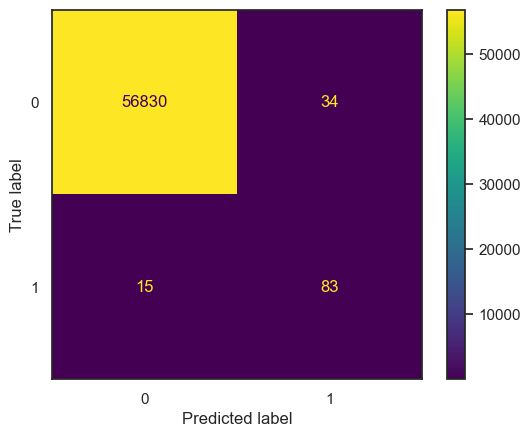

In [180]:
XGB_tune, cm = Model(XGBClassifier(tree_method = 'gpu_hist'), X_testing = X_test_final, 
                     y_testing = y_test)
ConfusionMatrixDisplay(cm).plot()

The final model is XGBoost with default parameters, achieving a ROC AUC of 0.923 which is higher than the validation. 

ROC AUC: 0.908


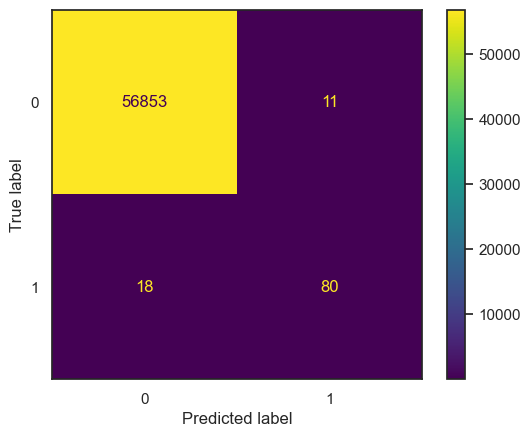

In [189]:
y_pred = Stack.predict(X_test_final)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
print('ROC AUC: %.3f' % roc_auc_score(y_test, y_pred))